**Installing libraries**



In [1]:
# Colab cell 1
!pip install -q tensorflow tensorflow_datasets matplotlib pandas opencv-python

import os, sys, json, math, glob, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print("TF", tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE


TF 2.19.0


**Downloading Food-101**

In [2]:
# Colab cell 2
# 1) In Colab upload your kaggle.json (from your Kaggle account -> API)
from google.colab import files
print("Upload kaggle.json (from Kaggle account -> API -> Create New Token)")
files.upload()  # choose kaggle.json file

# 2) move it into place and download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3) download and unzip
!kaggle datasets download -d dansbecker/food-101 -p /content --unzip


Upload kaggle.json (from Kaggle account -> API -> Create New Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
^C


**Fixing errors and downloading DataSet**

In [4]:
import tensorflow_datasets as tfds

# Load Food101 dataset
(ds_train, ds_val), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label)
    with_info=True,
)

print(ds_info)
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.CLVYPZ_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.CLVYPZ_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101

**Loading Dataset with TFDS**

In [12]:
(ds_train, ds_val), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    as_supervised=True,  # (image, label)
    with_info=True,
)
class_names = ds_info.features["label"].names
num_classes = ds_info.features["label"].num_classes
print("Total classes:", num_classes)
subset_classes = class_names[:10]   # اختر أول 10 classes
subset_indices = [class_names.index(c) for c in subset_classes]

def filter_subset(image, label):
    return tf.reduce_any([tf.equal(label, i) for i in subset_indices])

ds_train = ds_train.filter(filter_subset)
ds_val   = ds_val.filter(filter_subset)

print("Subset classes:", subset_classes)

Total classes: 101
Subset classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


**Preprocessing images**

In [13]:
IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [14]:
default_cal = 250
cal_dict = {c: default_cal for c in subset_classes}
cal_dict.update({
    "pizza": 285,
    "hamburger": 295,
    "french_fries": 312,
    "ice_cream": 207,
    "sushi": 200,
    "spaghetti_bolognese": 350,
    "caesar_salad": 180,
})
calories_ordered = np.array([cal_dict.get(c, default_cal) for c in subset_classes], dtype=np.float32)

**Build Model (MobileNetV2)**

In [15]:
def add_calories(image, label):
    calories = tf.gather(calories_ordered, label)
    return image, (label, calories)

train_ds = train_ds.map(add_calories)
val_ds   = val_ds.map(add_calories)


****

In [16]:
from tensorflow.keras import layers, models, optimizers

base = tf.keras.applications.MobileNetV2(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="avg", weights="imagenet"
)
base.trainable = False  # freeze backbone

inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inp, training=False)
x = layers.Dropout(0.3)(x)

class_out = layers.Dense(len(subset_classes), activation="softmax", name="class_output")(x)
calorie_out = layers.Dense(1, activation="linear", name="calorie_output")(x)

model = models.Model(inputs=inp, outputs=[class_out, calorie_out])

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss={"class_output": "sparse_categorical_crossentropy", "calorie_output": "mse"},
    metrics={"class_output": "accuracy", "calorie_output": "mae"},
    loss_weights={"class_output": 1.0, "calorie_output": 0.5},
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 1280)      │  2,257,984 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 10)        │     12,810 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ calorie_output      │ (None, 1)         │      1,281 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train (Fast Demo: 3 epochs)**

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
    235/Unknown 206s 781ms/step - calorie_output_loss: 49548.5859 - calorie_output_mae: 221.1480 - class_output_accuracy: 0.3777 - class_output_loss: 1.9100 - loss: 24776.3086

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


235/235 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - calorie_output_loss: 49502.6602 - calorie_output_mae: 221.0353 - class_output_accuracy: 0.3783 - class_output_loss: 1.9080 - loss: 24753.7949 - val_calorie_output_loss: 21233.0117 - val_calorie_output_mae: 145.2305 - val_class_output_accuracy: 0.6928 - val_class_output_loss: 0.8830 - val_loss: 10739.7324
Epoch 2/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 185s 545ms/step - calorie_output_loss: 16278.5420 - calorie_output_mae: 124.1268 - class_output_accuracy: 0.6507 - class_output_loss: 1.0404 - loss: 8140.5005 - val_calorie_output_loss: 6526.2778 - val_calorie_output_mae: 74.6625 - val_class_output_accuracy: 0.7252 - val_class_output_loss: 0.7982 - val_loss: 3292.5571
Epoch 3/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 115s 489ms/step - calorie_output_loss: 5083.9727 - calorie_output_mae: 63.0986 - class_output_accuracy: 0.6885 - class_output_loss: 0.8977 - loss: 2542.9514 - val_calorie_output_loss: 2733.1252 - val_calorie_output_mae: 43.9941 - val_class_output_accur

**Inference Function**

In [19]:
def predict_image(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    img = img[tf.newaxis, ...]

    probs, cal_pred = model.predict(img)
    probs = probs[0]

    pred_idx = np.argmax(probs)
    pred_class = subset_classes[pred_idx]

    argmax_cal = calories_ordered[pred_idx]
    expected_cal = float(np.dot(probs, calories_ordered))

    return {
        "predicted_class": pred_class,
        "confidence": float(probs[pred_idx]),
        "argmax_calories": float(argmax_cal),
        "expected_calories": expected_cal,
    }

**Test on a sample**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


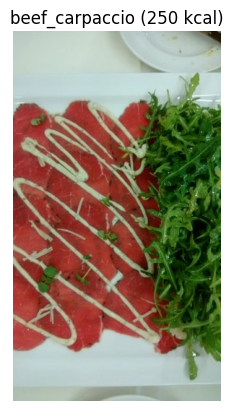

{'predicted_class': 'beef_carpaccio', 'confidence': 0.9772573709487915, 'argmax_calories': 250.0, 'expected_calories': 249.99998474121094}


In [20]:
for img, label in ds_val.take(1):
    result = predict_image(img.numpy())
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.title(f"{result['predicted_class']} ({result['expected_calories']:.0f} kcal)")
    plt.show()
    print(result)